In [1]:
using DataFrames
using CSV
using JuMP, GLPK

In [2]:
#WPrzemysław Szufel, orkshop on Optimziation Techniques for Data Science
# in Python and Julia, Fields Institute
distance_data = CSV.read("distance_UofT.csv", header=[:i, :j, :dist]);
N = length(unique(distance_data.i))
const distance_mx = zeros(Float64,(N,N))
for r in 1:nrow(distance_data)
   distance_mx[distance_data.i[r],distance_data.j[r]] = distance_data.dist[r]
end

In [3]:
distance_mx

5×5 Array{Float64,2}:
  0.0  4.0   2.0  9.0  12.0
  4.0  0.0   7.0  5.0   5.0
  2.0  7.0   0.0  4.0  10.0
  9.0  5.0   4.0  0.0   3.0
 12.0  5.0  10.0  3.0   0.0

In [4]:
#http://opensourc.es/blog/mip-tsp
m = Model(with_optimizer(GLPK.Optimizer))
@variable(m, x[f=1:N, t=1:N], Bin)
@objective(m, Min, sum( x[i, j]*distance_mx[i,j] for i=1:N,j=1:N))
@constraint(m, notself[i=1:N], x[i, i] == 0)
@constraint(m, oneout[i=1:N], sum(x[i, 1:N]) == 1)
@constraint(m, onein[j=1:N], sum(x[1:N, j]) == 1)
for f=1:N, t=1:N
    @constraint(m, x[f, t]+x[t, f] <= 1)
end

In [5]:
function getcycle(m,N)
    N = size(x)[1]
    x_val = JuMP.value.(x)
    # find cycle
    cycle_idx = Int[]
    push!(cycle_idx, 1)
    while true
        v, idx = findmax(x_val[cycle_idx[end],1:N])
        if idx == cycle_idx[1]
            break
        else
            push!(cycle_idx,idx)
        end
    end
    cycle_idx
end

getcycle (generic function with 1 method)

In [6]:
function is_tsp_solved(m, cycle_idx, N)
    println("cycle_idx: ", cycle_idx)
    println("Length: ", length(cycle_idx))
    if length(cycle_idx) < N
        cc = @constraint(m, sum(x[cycle_idx,cycle_idx]) <= length(cycle_idx)-1)
        println("added a constraint")
        return false
    end
    return true
end

is_tsp_solved (generic function with 1 method)

In [7]:
while true
    optimize!(m)
    cycle_idx = getcycle(m, N)
    if is_tsp_solved(m, cycle_idx,N)
        break;
    end
end

cycle_idx: [1, 3, 4, 5, 2]
Length: 5


In [8]:
POI_gps = CSV.read("UofT.csv");

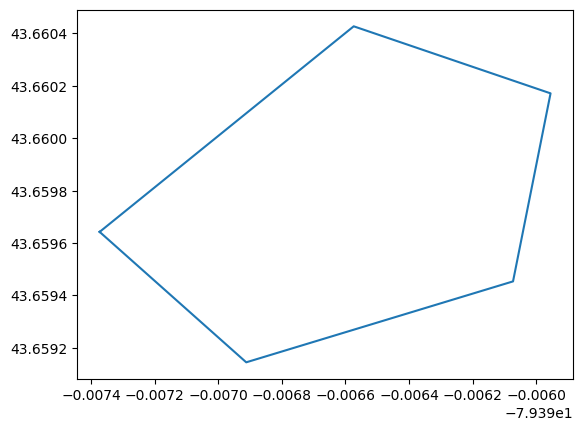

In [9]:
using PyPlot
cycle_idx = getcycle(m,N)
ids = vcat(cycle_idx, cycle_idx[1])
PyPlot.cla()
PyPlot.ioff()
PyPlot.plot(POI_gps.long[ids], POI_gps.latt[ids])
PyPlot.display_figs()
PyPlot.show()

In [10]:
#required installation for map vizualiztion
#using Conda
#Conda.runconda(`install folium -c conda-forge`)
using PyCall
flm = pyimport("folium")

n=length(ids)

m = flm.Map(location=[POI_gps.latt[1],POI_gps.long[1]], zoom_start=18)

# m = flm.Map(location=[POI_gps.latt[1],POI_gps.long[1]])

for i in ids
    flm.CircleMarker(location=[POI_gps.latt[i], POI_gps.long[i]],radius = 10,color="crimson").add_to(m)
end

for k in ids
    flm.PolyLine([[POI_gps.latt[getindex(ids, k)], POI_gps.long[getindex(ids, k)]],[POI_gps.latt[getindex(ids, k+1)], POI_gps.long[getindex(ids, k+1)]]]
).add_to(m)
end

m

PyObject <folium.folium.Map object at 0x0000000060EEE7B8>

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = show(::IOContext{Base.GenericIOBuffer{Array{UInt8,1}}}, ::MIME{Symbol("text/html")}, ::PyObject) at PyCall.jl:895
└ @ PyCall C:\Users\drala\.julia\packages\PyCall\ttONZ\src\PyCall.jl:895
